In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-krylov-precond)=
# Preconditioning

An important aspect of MINRES and CG (and, by extension, GMRES) is that the convergence of a Krylov method can be expected to deteriorate as the condition number of the matrix increases. Even moderately large condition numbers can make the convergence impractically slow. Therefore it's common for these methods to be used with a technique to reduce the relevant condition number.

```{index} GMRES; preconditioning in, ! preconditioning
```

::::{proof:definition} Preconditioning
Given a linear system $\mathbf{A}\mathbf{x}=\mathbf{b}$, a **preconditioner** is a matrix $\mathbf{M}$ or equivalent linear transformation that modifies the system to be

:::{math}
:label: precond
(\mathbf{M}^{-1} \mathbf{A}) \mathbf{x} = \mathbf{M}^{-1}\mathbf{b}.
:::
::::
 
More specifically, {eq}`precond` is known as *left preconditioning*, but it is the simplest and most common type.

As usual, we do not want to actually compute $\mathbf{M}^{-1}$ for a given $\mathbf{M}$. Instead, we have a linear system with the matrix $\mathbf{M}^{-1}\mathbf{A}$. In a Krylov method, the operation "let $\mathbf{v}=\mathbf{A}\mathbf{u}$" becomes a two-step process:

1. Set $\mathbf{y}=\mathbf{A}\mathbf{u}$.
2. Solve $\mathbf{M}\mathbf{v}=\mathbf{y}$ for $\mathbf{v}$.

```{index} sparse matrix, LU factorization
```

As an implementation detail, it is common to provide the Krylov solver with code that does step 2; if the matrix $\mathbf{M}$ is given, the default is to use sparse factorization. 

There are competing objectives in the choice of $\mathbf{M}$. On one hand, we want $\mathbf{M}^{-1}\mathbf{A}\approx \mathbf{I}$ in some sense because that makes {eq}`precond` easy to solve by Krylov iteration. Hence $\mathbf{M}\approx \mathbf{A}$. On the other hand, we desire that solving the system $\mathbf{M}\mathbf{v}=\mathbf{y}$ be relatively fast. 

:::{proof:observation}
Good preconditioning is a matter of finding an easily inverted (i.e., quickly solvable) approximation of the original matrix. 
:::

## Diagonal preconditioning

One of the simplest choices for the preconditioner $\mathbf{M}$ is a diagonal matrix. This definitely meets the requirement of being fast to invert: the solution of $\mathbf{M}\mathbf{v}=\mathbf{y}$ is just $v_i=y_i/M_{ii}$. The only question is whether it can be chosen in such a way that $\mathbf{M}^{-1}\mathbf{A}$ is much more amenable to Krylov iterations than $\mathbf{A}$ is. This may be the case when the rows of $\mathbf{A}$ differ greatly in scale, or when $\mathbf{A}$ is diagonally dominant (see {eq}`diag-dominant`).

(demo-precond-diagonal)=
:::{proof:demo}
:::

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Here is an SPD matrix that arises from solving partial differential equations.

In [2]:
A = matrixdepot("wathen",60)
n = size(A,1)
@show n,nnz(A);

(n, nnz(A)) = (11041, 170161)


```{index} ! Julia; DiagonalPreconditioner
```

There is an easy way to use the diagonal elements of $\mathbf{A}$, or any other vector, as a diagonal preconditioner.

In [3]:
b = ones(n)
M = DiagonalPreconditioner(diag(A));

We now compare CG with and without the preconditioner.

(time_plain, time_prec) = (4.4388135, 3.764856792)


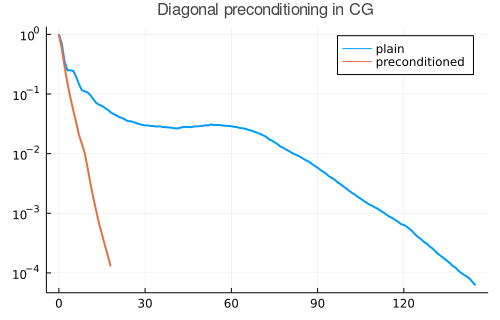

In [4]:
plain(b) = cg(A,b,maxiter=200,reltol=1e-4,log=true)
time_plain = @elapsed x,hist1 = plain(b)
prec(b) = cg(A,b,Pl=M,maxiter=200,reltol=1e-4,log=true)
time_prec = @elapsed x,hist2 = prec(b)
@show time_plain,time_prec

rr = hist1[:resnorm]
plot(0:length(rr)-1,rr/rr[1],yscale=:log10,label="plain")
rr = hist2[:resnorm]
plot!(0:length(rr)-1,rr/rr[1],yscale=:log10,label="preconditioned")
title!("Diagonal preconditioning in CG")

The diagonal preconditioner cut down substantially on the number of iterations. The effect on the total time is less dramatic, but this is not a large version of the problem.

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Incomplete factorization

```{index} ! LU factorization; incomplete
```

Another general-purpose technique is the **incomplete LU factorization**. Since true factorization of a sparse matrix usually leads to an undesirable amount of fill-in, incomplete LU sacrifices exact factors by dropping elements smaller than an adjustable threshold.

(demo-precond-gmres)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Here is a nonsymmetric matrix arising from a probabilistic model in computational chemistry.

In [5]:
A = sparse(matrixdepot("Watson/chem_master1"))
n = size(A,1)
@show n,nnz(A),issymmetric(A)

(n, nnz(A), issymmetric(A)) = (40401, 201201, false)


(40401, 201201, false)

Without a preconditioner, GMRES makes essentially no progress after 100 iterations.

In [6]:
b = rand(40000)
const GMRES = IterativeSolvers.gmres
x,history = GMRES(A,b,maxiter=100,reltol=1e-5,log=true)
resnorm = history[:resnorm]
@show resnorm[end] / resnorm[1];

resnorm[end] / resnorm[1] = 0.9684460183388263


```{index} ! Julia; ilu
```

The following version of incomplete LU factorization drops all sufficiently small values (i.e., replaces them with zeros). This keeps the number of nonzeros in the factors under control.

In [7]:
iLU = ilu(A,τ=0.25)
@show nnz(iLU)/nnz(A);

nnz(iLU) / nnz(A) = 9.654509669435043


The result is almost 10 times as dense as $\mathbf{A}$ and yet still not a true factorization of it. However, it's close enough for an approximate inverse in a preconditioner. The actual preconditioning matrix is $\mathbf{M}=\mathbf{L}\mathbf{U}$, but we just supply the factorization to `gmres`.

In [8]:
_,history = GMRES(A,b,Pl=iLU,maxiter=100,reltol=1e-5,log=true)
history

Converged after 7 iterations.

The $\tau$ parameter in `ilu` balances the accuracy of the iLU factorization with the time needed to compute it and invert it. As $\tau\to 0$, more of the elements are kept, making the preconditioner more effective but slower per iteration.

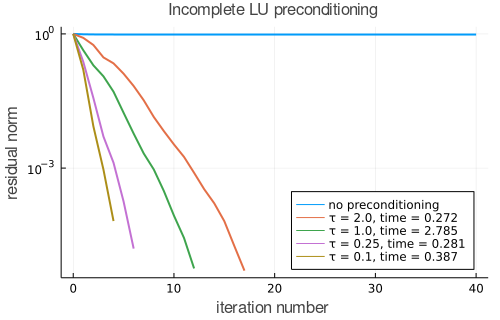

In [9]:
plt = plot(0:40,resnorm[1:41]/resnorm[1],label="no preconditioning",
        xaxis=("iteration number"),yaxis=(:log10,"residual norm"),
        leg=:bottomright,title="Incomplete LU preconditioning")
    for τ in [2,1,0.25,0.1]
        t = @elapsed iLU = ilu(A;τ)
        t += @elapsed _,history = GMRES(A,b,Pl=iLU,maxiter=100,
                                        reltol=1e-5,log=true)
        resnorm = history[:resnorm]
        label = "τ = $τ, time = $(round(t,digits=3))"
        plot!(0:length(resnorm)-1,resnorm/resnorm[1];label)
    end
plt

In any given problem, it's impossible to know in advance where the right balance lies between fidelity and speed for the preconditioner.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

In practice, good preconditioning is often as important, if not more important, than the specific choice of Krylov method. Effective preconditioning may require deep understanding of the underlying application, however, which limits our ability to go into further details. For instance, the linear system may be some approximation of a continuous mathematical model, and then $\mathbf{M}$ can be derived by using a cruder form of the approximation. Krylov methods offer a natural way to exploit these and other approximate inverses.

## Exercises

(problem-precond-spd)=
1. ✍ Suppose $\mathbf{M}=\mathbf{R}^T\mathbf{R}$. Show that the eigenvalues of $\mathbf{R}^{-T}\mathbf{A}\mathbf{R}^{-1}$ are the same as the eigenvalues of $\mathbf{M}^{-1}\mathbf{A}$. (This observation underlies preconditioning variants for SPD matrices.)

2. ⌨ The object returned by `ilu` stores the factors in a way that optimizes sparse triangular substitution. You can recover the factors themselves via
    
    ```julia
    iLU = ilu(A,τ=0.1)   # for example
    L, U = I+iLU.L, iLU.U'
    ```

    In this problem, use `A = 1.5I + sprand(800,800,0.005)`.

    **(a)** Using $\tau=0.3$ for the factorization, plot the eigenvalues of $\mathbf{A}$ and of $\mathbf{M}^{-1}\mathbf{A}$ in the complex plane on side-by-side subplots. Do they support the notion that $\mathbf{M}^{-1}\mathbf{A}$ is "more like" an identity matrix than $\mathbf{A}$ is? (Hint: the matrices are small enough to convert to standard dense form for the use of `eigvals`.)

    **(b)** Repeat part (a) for $\tau=0.03$. Is $\mathbf{M}$ more accurate than in part (a), or less?

3. ⌨ (Continuation of [Exercise 8.5.5](problem-gmres-surround).) Let $\mathbf{B}$ be `diagm(1:100)`,  let $\mathbf{I}$ be `I(100)`, and let $\mathbf{Z}$ be a $100\times 100$ matrix of zeros. Define 
  
    $$
    \mathbf{A} = \begin{bmatrix}
      \mathbf{B} & \mathbf{I} \\ \mathbf{Z} & -\mathbf{B}
    \end{bmatrix}
    $$ 
  
    and let $\mathbf{b}$ be a 200-vector of ones. The matrix $\mathbf{A}$ is difficult for GMRES. 
  
    **(a)** Design a diagonal preconditioner $\mathbf{M}$, with all diagonal elements equal to $1$ or $-1$, such that $\mathbf{M}^{-1}\mathbf{A}$ has all positive eigenvalues. Apply `gmres` without restarts using this preconditioner and a tolerance of $10^{-10}$ for 100 iterations. Plot the convergence curve. 
  
    **(b)** Now design another diagonal preconditioner such that all the eigenvalues of $\mathbf{M}^{-1}\mathbf{A}$ are $1$, and apply preconditioned `gmres` again. How many iterations are apparently needed for convergence? 

4. ⌨ Let `A = matrixdepot("Bai/rdb2048")`, and let `b` be a vector of 2048 ones. In the steps below, use GMRES for up to 300 iterations without restarts and with a stopping tolerance of $10^{-4}$.

    **(a)** Time the GMRES solution without preconditioning. Verify that convergence was achieved. 

    **(b)** Show that diagonal preconditioning is not helpful for this problem.

    **(c)** To two digits, find a value of $\tau$ in iLU such that the preconditioned method transitions from effective and faster than part (a) to ineffective.